# RNA-seq Differential Expression Analysis of Blood Cell Types

**Overview:**  
This notebook analyzes RNA-seq expression data from multiple blood cell types to identify genes differentially expressed in CD4 T-cells compared to other cell types.



## 1. Setup and Imports
# This section imports all the necessary Python libraries and modules used throughout the analysis.

- `pandas` and `numpy` for data handling and numerical operations.
- `matplotlib` and `seaborn` for data visualization.
- `sklearn.decomposition.PCA` for principal component analysis.
- Statistical testing libraries: `scipy.stats` and `statsmodels` for differential expression analysis.
- `warnings` to manage and suppress expected warnings during computation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import warnings

# Optional: suppress expected warnings (e.g., about precision loss)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 2. Data Loading and Preprocessing
# Load expression data and prepare sample metadata

- Assume `df_log2` is your log2-transformed expression DataFrame.
- Metadata dictionaries:
  - `lib_to_gsm`: maps library/sample IDs (e.g., 'lib221') to GSM IDs.
  - `sample2type`: maps GSM IDs (possibly quoted) to cell types.

- The following code cleans sample metadata and filters genes with low variance.

In [14]:

df = pd.read_csv("../data/GSE60424_GEOSubmit_FC1to11_normalized_counts.txt", sep="\t", index_col=0)

print("Data shape:", df.shape)
df.head()


Data shape: (50045, 134)


,lib221,lib222,lib223,lib224,lib225,lib226,lib227,lib228,lib229,lib230,...,lib346,lib347,lib348,lib349,lib350,lib351,lib352,lib353,lib354,lib355
genenames,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1,0,1,1,1,0,0,0,2,1,...,1,0,1,0,0,0,1,1,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,23,22,25,28,25,41,18,12,14,20,...,28,19,35,37,25,17,22,25,25,30
ENSG00000000457,11,11,14,17,11,32,9,24,19,16,...,18,13,15,26,5,23,17,15,14,14
ENSG00000000460,3,3,3,3,2,4,5,9,4,6,...,11,9,5,4,7,12,8,8,11,5


In [15]:
print("Row index sample:", df.index[:5].tolist())
print("Column names sample:", df.columns[:5].tolist())


Row index sample: ['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460']
Column names sample: ['lib221', 'lib222', 'lib223', 'lib224', 'lib225']


In [16]:
df.describe

<bound method NDFrame.describe of                  lib221  lib222  lib223  lib224  lib225  lib226  lib227  \
genenames                                                                 
ENSG00000000003       1       0       1       1       1       0       0   
ENSG00000000005       0       0       0       0       0       0       0   
ENSG00000000419      23      22      25      28      25      41      18   
ENSG00000000457      11      11      14      17      11      32       9   
ENSG00000000460       3       3       3       3       2       4       5   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000261837       0       0       0       0       0       0       0   
ENSG00000261838       0       0       0       0       0       0       0   
ENSG00000261839       0       0       0       0       0       0       0   
ENSG00000261840       1       1       1       1       1       0       2   
ENSG00000261842       0       0       0       0       0       0   

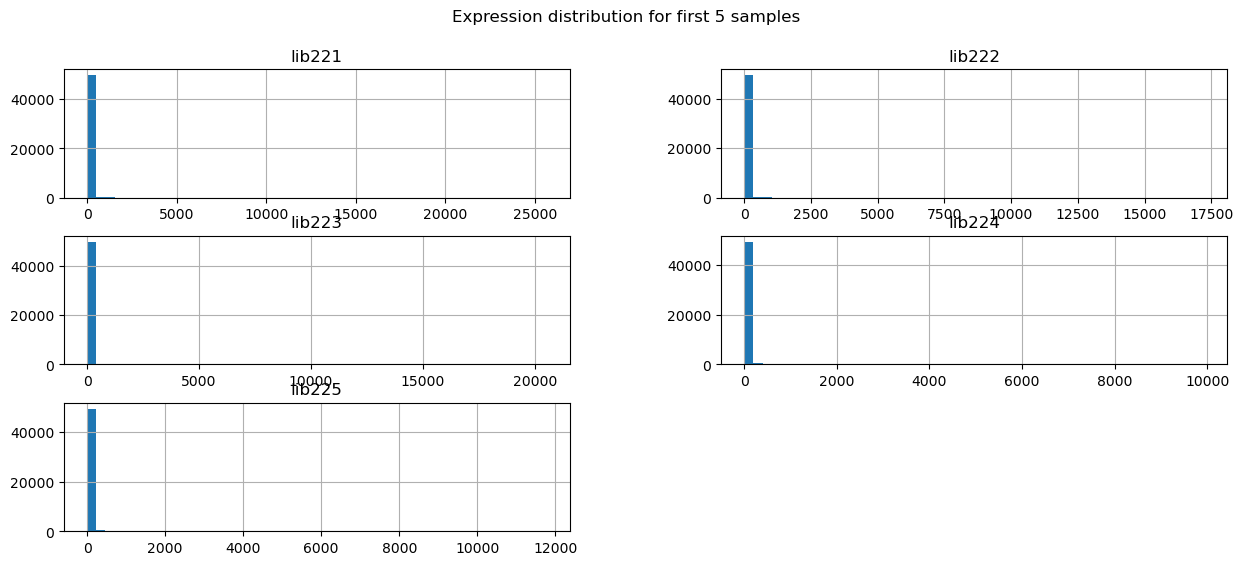

In [22]:
df.iloc[:, :5].hist(bins=50, figsize=(15,6))
plt.suptitle("Expression distribution for first 5 samples")
plt.show()

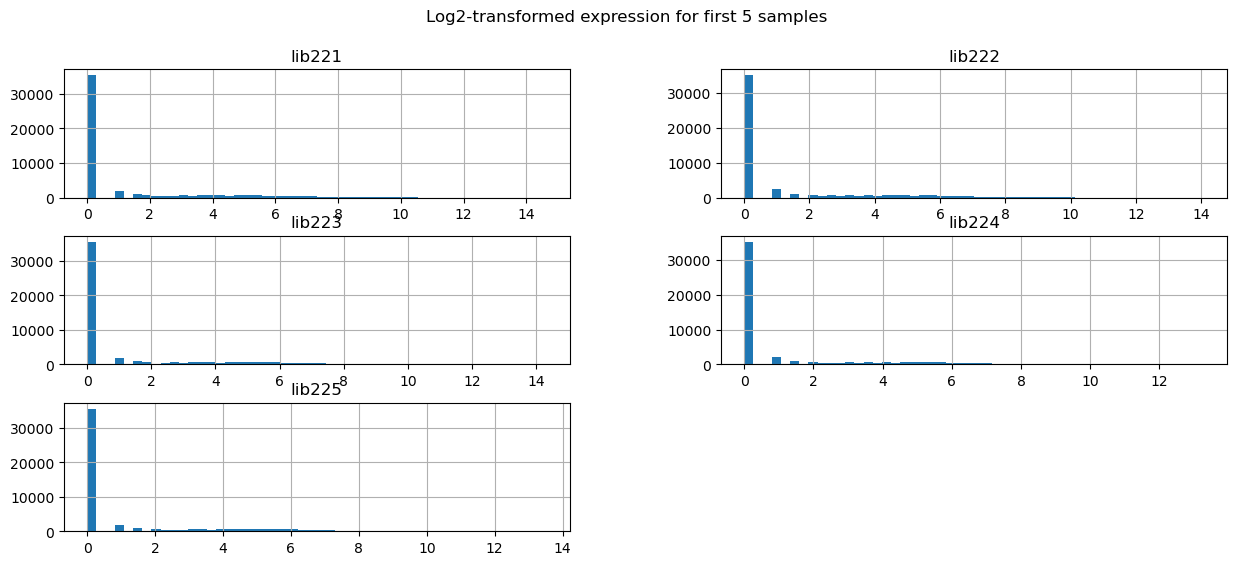

In [24]:
# Log2-transform (adding 1 to avoid log(0))
df_log2 = np.log2(df + 1)

# Plot the transformed distributions
df_log2.iloc[:, :5].hist(bins=50, figsize=(15,6))
plt.suptitle("Log2-transformed expression for first 5 samples")
plt.show()


## 3. Principal Component Analysis (PCA)

# Principal Component Analysis (PCA) is performed to reduce the dimensionality of the gene expression data. This helps to identify the main axes (principal components) capturing the most variance in the data.

- PCA helps visualize sample clustering and patterns among different cell types.
- We compute loadings to find which genes contribute most to each principal component.
- Top contributing genes for PC1 and PC2 are identified for further analysis.

This step provides insight into the overall structure of the dataset before focusing on differential expression.

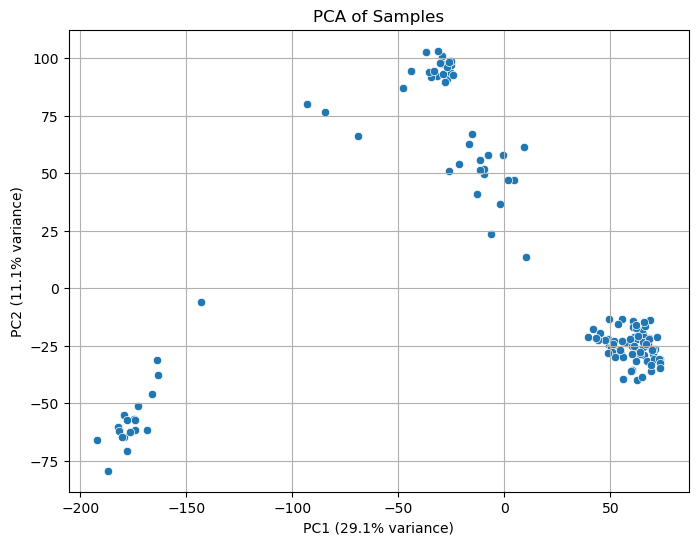

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Transpose so samples are rows, genes are columns
X = df_log2.T

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=X.index)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2")
plt.title("PCA of Samples")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True)
plt.show()


In [30]:
samples = []
characteristics_lines = []

with open(sm_path, 'r') as f:
    for line in f:
        if line.startswith('!Sample_geo_accession'):
            samples = line.strip().split('\t')[1:]
        elif line.startswith('!Sample_characteristics_ch1'):
            characteristics_lines.append(line.strip().split('\t')[1:])

print(f"Found {len(samples)} samples")
print(f"Found {len(characteristics_lines)} characteristics lines")

# characteristics_lines is a list of lists, each sublist length == number of samples

# Now, for each sample, gather all characteristics values (from each line)
sample_characteristics = {sample: [] for sample in samples}

for char_line in characteristics_lines:
    for sample, val in zip(samples, char_line):
        sample_characteristics[sample].append(val)

# Let's see the first sample's characteristics
print(f"Sample {samples[0]} characteristics:")
for c in sample_characteristics[samples[0]]:
    print(f"  {c}")

# Now find which characteristic is celltype by searching for 'celltype' keyword
cell_type_index = None

for i, val in enumerate(sample_characteristics[samples[0]]):
    if 'celltype' in val.lower():
        cell_type_index = i
        print(f"Cell type found at characteristic index: {cell_type_index}")
        break

if cell_type_index is None:
    print("Could not find celltype in characteristics")
else:
    # Extract cell type for each sample by splitting on colon
    sample2type = {}
    for sample in samples:
        val = sample_characteristics[sample][cell_type_index]
        cell_type = val.split(':',1)[1].strip() if ':' in val else val
        sample2type[sample] = cell_type

    print(sample2type)


Found 134 samples
Found 15 characteristics lines
Sample "GSM1479433" characteristics:
  "age: 32"
  "cellcount: --"
  "celltype: Whole Blood"
  "collectiondate: June 26 2012"
  "diseasestatus: Healthy Control"
  "donorid: 44"
  "gender: F"
  "index: 21"
  "race: Hispanic"
  "samplename: 44_Tempus"
  "smoker: --"
  "time since last flare (months): --"
  "time since steroid dose: --"
  "time since symptom onset (yrs): --"
  "years since diagnosis: --"
Cell type found at characteristic index: 2
{'"GSM1479433"': 'Whole Blood"', '"GSM1479434"': 'Whole Blood"', '"GSM1479435"': 'Whole Blood"', '"GSM1479436"': 'Whole Blood"', '"GSM1479437"': 'Whole Blood"', '"GSM1479438"': 'Neutrophils"', '"GSM1479439"': 'Monocytes"', '"GSM1479440"': 'B-cells"', '"GSM1479441"': 'CD4"', '"GSM1479442"': 'CD8"', '"GSM1479443"': 'NK"', '"GSM1479444"': 'Neutrophils"', '"GSM1479445"': 'Monocytes"', '"GSM1479446"': 'B-cells"', '"GSM1479447"': 'CD4"', '"GSM1479448"': 'CD8"', '"GSM1479449"': 'Neutrophils"', '"GSM147945

In [31]:
with open(sm_path) as f:
    for line in f:
        if line.startswith('!Sample_title') or line.startswith('!Sample_geo_accession') or line.startswith('!Sample_source_name_ch1'):
            print(line)


!Sample_title	"lib221"	"lib222"	"lib223"	"lib224"	"lib225"	"lib226"	"lib227"	"lib228"	"lib229"	"lib230"	"lib231"	"lib232"	"lib233"	"lib234"	"lib235"	"lib236"	"lib237"	"lib238"	"lib239"	"lib240"	"lib241"	"lib242"	"lib243"	"lib244"	"lib245"	"lib246"	"lib247"	"lib248"	"lib249"	"lib250"	"lib251"	"lib252"	"lib253"	"lib254"	"lib255"	"lib256"	"lib257"	"lib258"	"lib259"	"lib260"	"lib261"	"lib262"	"lib263"	"lib264"	"lib265"	"lib266"	"lib267"	"lib268"	"lib269"	"lib270"	"lib271"	"lib272"	"lib273"	"lib274"	"lib275"	"lib276"	"lib277"	"lib278"	"lib279"	"lib280"	"lib281"	"lib282"	"lib283"	"lib284"	"lib285"	"lib286"	"lib288"	"lib289"	"lib290"	"lib291"	"lib292"	"lib293"	"lib294"	"lib295"	"lib296"	"lib297"	"lib298"	"lib299"	"lib300"	"lib301"	"lib302"	"lib303"	"lib304"	"lib305"	"lib306"	"lib307"	"lib308"	"lib309"	"lib310"	"lib311"	"lib312"	"lib313"	"lib314"	"lib315"	"lib316"	"lib317"	"lib318"	"lib319"	"lib320"	"lib321"	"lib322"	"lib323"	"lib324"	"lib325"	"lib326"	"lib327"	"lib328"	"lib329"	"lib330"	"lib3

In [34]:
# Path to your metadata file
sm_path = "../data/GSE60424_series_matrix.txt"

# Initialize variables to hold the lines we want
sample_title_line = None
sample_geo_accession_line = None

# Open and read line by line
with open(sm_path, 'r') as f:
    for line in f:
        if line.startswith('!Sample_title'):
            # Strip newline, split by tab, save the whole line as list
            sample_title_line = line.strip().split('\t')
        elif line.startswith('!Sample_geo_accession'):
            sample_geo_accession_line = line.strip().split('\t')

# Now you have two lists: sample_title_line and sample_geo_accession_line
print("Sample title line first 5 elements:", sample_title_line[:5])
print("Sample geo accession line first 5 elements:", sample_geo_accession_line[:5])


Sample title line first 5 elements: ['!Sample_title', '"lib221"', '"lib222"', '"lib223"', '"lib224"']
Sample geo accession line first 5 elements: ['!Sample_geo_accession', '"GSM1479433"', '"GSM1479434"', '"GSM1479435"', '"GSM1479436"']


In [35]:
# Extract lib sample names and GSM IDs from the metadata lines (strings including quotes)
lib_samples = [x.strip('"') for x in sample_title_line[1:]]  # skip first element '!Sample_title'
gsm_ids = [x.strip('"') for x in sample_geo_accession_line[1:]]  # skip '!Sample_geo_accession'

# Build a mapping lib -> GSM
lib_to_gsm = dict(zip(lib_samples, gsm_ids))

# Now map lib -> cell type using your sample2type dictionary
lib_to_celltype = {}

for lib, gsm in lib_to_gsm.items():
    # GSM keys in sample2type have quotes, so strip them for matching or adjust keys accordingly
    gsm_key = f'"{gsm}"' if gsm not in sample2type else gsm  # adjust if needed

    # Try exact match, or try adding quotes if needed
    if gsm_key in sample2type:
        lib_to_celltype[lib] = sample2type[gsm_key]
    elif gsm in sample2type:
        lib_to_celltype[lib] = sample2type[gsm]
    else:
        lib_to_celltype[lib] = 'Unknown'

# Check the mapping for first few libs
for k in list(lib_to_celltype.keys())[:10]:
    print(f"{k}: {lib_to_celltype[k]}")


lib221: Whole Blood"
lib222: Whole Blood"
lib223: Whole Blood"
lib224: Whole Blood"
lib225: Whole Blood"
lib226: Neutrophils"
lib227: Monocytes"
lib228: B-cells"
lib229: CD4"
lib230: CD8"


In [36]:
# Clean trailing quotes from all values in lib_to_celltype dict
for lib, celltype in lib_to_celltype.items():
    lib_to_celltype[lib] = celltype.rstrip('"')

# Check the cleaned mapping
for lib, celltype in list(lib_to_celltype.items())[:10]:
    print(f"{lib}: {celltype}")


lib221: Whole Blood
lib222: Whole Blood
lib223: Whole Blood
lib224: Whole Blood
lib225: Whole Blood
lib226: Neutrophils
lib227: Monocytes
lib228: B-cells
lib229: CD4
lib230: CD8


In [37]:
import pandas as pd

# Make sure your df columns match the lib keys exactly
print("Expression data columns sample:", df.columns[:5])

# Create a Series mapping lib/sample to cell type
cell_types = pd.Series(lib_to_celltype)

# Align the order of cell_types to df columns (in case order differs)
cell_types = cell_types.reindex(df.columns)

# Check for any libs without cell type annotation
missing = cell_types.isna()
if missing.any():
    print("Warning: missing cell type for these samples:")
    print(cell_types[missing])

# Now you have a cell_types Series indexed by sample/library names, matching df columns
print(cell_types.head())

# Optional: Add cell type info as DataFrame attribute or keep for plotting/grouping
df.attrs['cell_types'] = cell_types


Expression data columns sample: Index(['lib221', 'lib222', 'lib223', 'lib224', 'lib225'], dtype='object')
lib221    Whole Blood
lib222    Whole Blood
lib223    Whole Blood
lib224    Whole Blood
lib225    Whole Blood
dtype: object


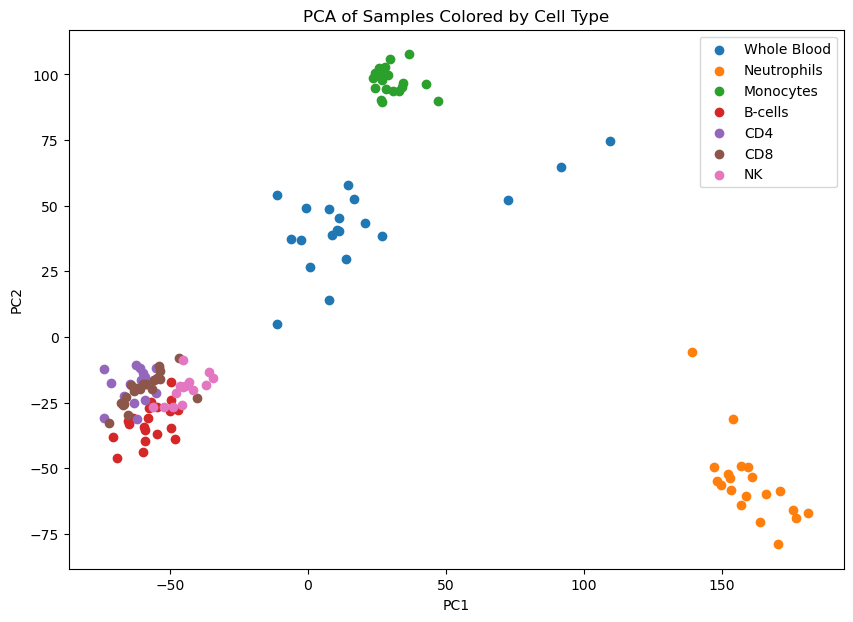

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize data (genes as rows, samples as columns)
scaled_data = StandardScaler().fit_transform(df.T)

# Run PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA colored by cell type
plt.figure(figsize=(10,7))
unique_cell_types = cell_types.unique()

for cell_type in unique_cell_types:
    idx = cell_types[cell_types == cell_type].index
    points = pca_results[[df.columns.get_loc(i) for i in idx]]
    plt.scatter(points[:,0], points[:,1], label=cell_type)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Samples Colored by Cell Type")
plt.legend()
plt.show()


## 4. Visualizing Top Genes from PCA

# To better understand which genes drive the main variation captured by PCA, we identify the top genes contributing to the first two principal components.

- The top genes for PC1 and PC2 are selected based on their absolute loadings.
- We visualize the expression patterns of these top genes across samples using a heatmap.
- Samples are grouped or colored by cell type to observe potential biological trends.

This visualization provides an intuitive look at gene expression differences underlying the major sources of variation.

In [39]:
# PCA loadings: each gene’s contribution to each PC
loadings = pca.components_.T  # shape: genes x PCs

# Create a DataFrame of loadings for PC1 and PC2
loadings_df = pd.DataFrame(loadings[:, :2], index=df.index, columns=['PC1', 'PC2'])

# Sort by absolute loading for PC1 and PC2 separately
top_genes_pc1 = loadings_df['PC1'].abs().sort_values(ascending=False).head(10)
top_genes_pc2 = loadings_df['PC2'].abs().sort_values(ascending=False).head(10)

print("Top 10 genes contributing to PC1:")
print(top_genes_pc1)

print("\nTop 10 genes contributing to PC2:")
print(top_genes_pc2)


Top 10 genes contributing to PC1:
genenames
ENSG00000135956    0.012648
ENSG00000101150    0.012632
ENSG00000116701    0.012627
ENSG00000075785    0.012626
ENSG00000005238    0.012603
ENSG00000114353    0.012602
ENSG00000144848    0.012589
ENSG00000171777    0.012558
ENSG00000160685    0.012552
ENSG00000101336    0.012550
Name: PC1, dtype: float64

Top 10 genes contributing to PC2:
genenames
ENSG00000178741    0.019020
ENSG00000118640    0.018934
ENSG00000182718    0.018920
ENSG00000110955    0.018885
ENSG00000110442    0.018858
ENSG00000093010    0.018854
ENSG00000105438    0.018821
ENSG00000108883    0.018808
ENSG00000134590    0.018711
ENSG00000117450    0.018695
Name: PC2, dtype: float64


In [57]:
# Combine top genes from PC1 and PC2 (as gene names)
top_genes = list(top_genes_pc1.index) + list(top_genes_pc2.index)

# Remove duplicates if any
top_genes = list(set(top_genes))

# Extract expression for those genes from your main DataFrame df
expr_top = df.loc[top_genes]

# Sort sample columns by their cell type label
sample_order = sorted(expr_top.columns, key=lambda s: lib_to_celltype.get(s, 'Unknown'))

# Reorder the columns of expr_top accordingly
expr_top_sorted = expr_top[sample_order]

# Now expr_top_sorted is ready for plotting or further analysis


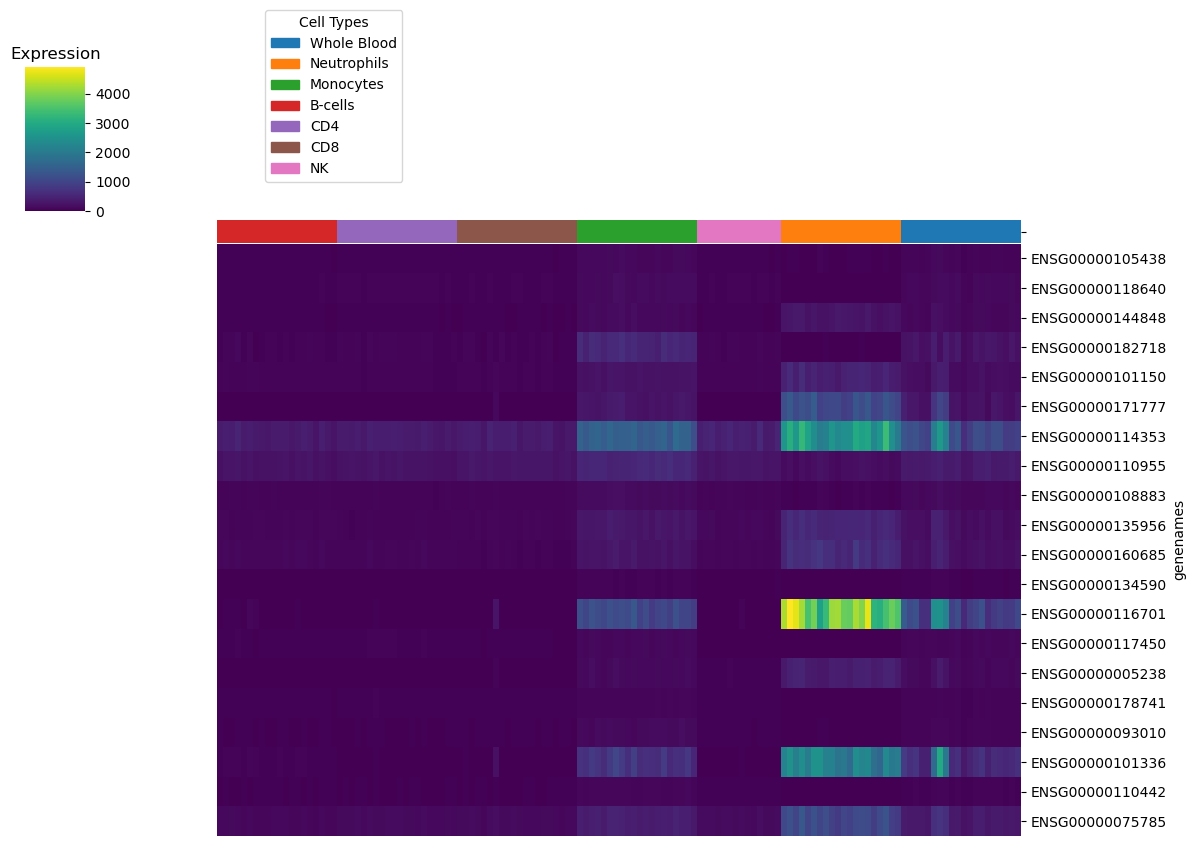

In [59]:
import matplotlib.patches as mpatches

# Create legend patches for cell types
patches = [mpatches.Patch(color=color, label=ctype) for ctype, color in lut.items()]

# Get the current clustermap figure and axes
g = sns.clustermap(
    expr_top_sorted,
    cmap="viridis",
    col_colors=col_colors,
    figsize=(12, 8),
    yticklabels=True,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
)

# Add a label to the colorbar
g.cax.set_title("Expression", fontsize=12)  # 'Expression' is your label


# Add legend outside the heatmap to the right
plt.legend(
    handles=patches,
    title='Cell Types',
    bbox_to_anchor=(4, 0.8),
    loc='center left',
    borderaxespad=0.,
    fontsize='medium'
)

plt.show()


## 5. Differential Expression Analysis

# This section identifies genes that are significantly differentially expressed between the target cell type (e.g., CD4 T-cells) and all other cell types.

- We perform gene-wise t-tests comparing expression levels in the target group vs. others.
- P-values are adjusted for multiple testing using the Benjamini-Hochberg procedure to control the false discovery rate.
- The results include log2 fold changes, raw p-values, and adjusted p-values, highlighting the most differentially expressed genes.

This analysis helps pinpoint genes potentially important for defining the biology of the target cell type.


In [65]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Sample expression data (genes x samples) and sample2type mapping
expr_df = df_log2  # assuming this is already log-transformed
sample_types = pd.Series(sample2type)  # index: sample ID, value: cell type

# Choose a cell type to compare (e.g., 'CD4')
target_type = 'CD4'

# Get sample lists
target_samples = sample_types[sample_types == target_type].index
other_samples = sample_types[sample_types != target_type].index

# Ensure samples exist in expression data
target_samples = [s for s in target_samples if s in expr_df.columns]
other_samples = [s for s in other_samples if s in expr_df.columns]

print(f"Number of '{target_type}' samples: {len(target_samples)}")
print(f"Number of other samples: {len(other_samples)}")

# Run t-test for each gene
pvals = []
logfc = []

for gene in expr_df.index:
    x = expr_df.loc[gene, target_samples]
    y = expr_df.loc[gene, other_samples]

    # Skip if either group has fewer than 2 samples (too small for t-test)
    if len(x) < 2 or len(y) < 2:
        pvals.append(np.nan)
        logfc.append(np.nan)
        continue

    # Skip genes with no variance in both groups
    if x.std() == 0 and y.std() == 0:
        pvals.append(1.0)
        logfc.append(0.0)
        continue

    stat, p = ttest_ind(x, y, equal_var=False)
    pvals.append(p)
    logfc.append(np.log2(x.mean() + 1e-6) - np.log2(y.mean() + 1e-6))

# Adjust p-values for multiple testing (ignore NaNs)
valid_pvals = np.array([p if not np.isnan(p) else 1.0 for p in pvals])
adj_pvals = multipletests(valid_pvals, method='fdr_bh')[1]

# Create results DataFrame
dea_df = pd.DataFrame({
    'log2FC': logfc,
    'pval': pvals,
    'adj_pval': adj_pvals
}, index=expr_df.index)

# Sort by adjusted p-value, ignoring NaNs
dea_df = dea_df.dropna(subset=['adj_pval']).sort_values(by='adj_pval')

# Show top 10
print(dea_df.head(10))


Number of 'CD4' samples: 0
Number of other samples: 0
                 log2FC  pval  adj_pval
genenames                              
ENSG00000261797     NaN   NaN       1.0
ENSG00000261798     NaN   NaN       1.0
ENSG00000261799     NaN   NaN       1.0
ENSG00000261800     NaN   NaN       1.0
ENSG00000261801     NaN   NaN       1.0
ENSG00000261803     NaN   NaN       1.0
ENSG00000261804     NaN   NaN       1.0
ENSG00000261807     NaN   NaN       1.0
ENSG00000261787     NaN   NaN       1.0
ENSG00000261788     NaN   NaN       1.0


In [66]:
# Step 1: clean sample2type keys: remove quotes if present
clean_sample2type = {k.strip('"'): v.strip('"') for k, v in sample2type.items()}

# Step 2: create lib to celltype map by using lib_to_gsm + clean_sample2type
lib_to_celltype = {}
for lib, gsm in lib_to_gsm.items():
    gsm_clean = gsm.strip('"')
    celltype = clean_sample2type.get(gsm_clean, 'Unknown')
    lib_to_celltype[lib] = celltype

# Step 3: create a pandas Series matching expression df columns to cell types
sample_types = pd.Series(lib_to_celltype)

# Check if all columns have cell types now
print(sample_types.head(10))


lib221    Whole Blood
lib222    Whole Blood
lib223    Whole Blood
lib224    Whole Blood
lib225    Whole Blood
lib226    Neutrophils
lib227      Monocytes
lib228        B-cells
lib229            CD4
lib230            CD8
dtype: object


In [67]:
target_type = 'CD4'  # or pick another from sample_types.unique()

# Find samples matching cell types in your expression df
target_samples = sample_types[sample_types == target_type].index.intersection(expr_df.columns)
other_samples = sample_types[sample_types != target_type].index.intersection(expr_df.columns)

print(f"Number of '{target_type}' samples: {len(target_samples)}")
print(f"Number of other samples: {len(other_samples)}")

# Then run your DE analysis code with these sample lists...

Number of 'CD4' samples: 20
Number of other samples: 114


In [72]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Assume these are already defined from your earlier steps:
# df_log2 : pandas DataFrame of log2-transformed expression (genes x lib samples)
# lib_to_gsm : dict mapping lib sample names to GSM IDs, e.g. {'lib221': 'GSM1479433', ...}
# sample2type : dict mapping GSM IDs (possibly quoted) to cell types, e.g. {'"GSM1479433"': 'Whole Blood"', ...}

# Step 1: Clean sample2type keys and values (strip quotes)
clean_sample2type = {k.strip('"'): v.strip('"') for k, v in sample2type.items()}

# Step 2: Map lib sample names to cell types using lib_to_gsm and clean_sample2type
lib_to_celltype = {}
for lib, gsm in lib_to_gsm.items():
    gsm_clean = gsm.strip('"')
    celltype = clean_sample2type.get(gsm_clean, 'Unknown')
    lib_to_celltype[lib] = celltype

# Convert to pandas Series for easy indexing
sample_types = pd.Series(lib_to_celltype)

# Step 3: Differential expression analysis setup
expr_df = df_log2  # your log2-transformed expression DataFrame

# Filter out genes with very low variance across all samples
variance_threshold = 1e-5
expr_df_filtered = expr_df.loc[expr_df.var(axis=1) > variance_threshold]
print(f"Genes before filtering: {expr_df.shape[0]}, after filtering: {expr_df_filtered.shape[0]}")

# Choose a target cell type to compare against all others
target_type = 'CD4'  # change as needed

# Get sample lists that exist both in sample_types and expression columns
target_samples = sample_types[sample_types == target_type].index.intersection(expr_df_filtered.columns)
other_samples = sample_types[sample_types != target_type].index.intersection(expr_df_filtered.columns)

print(f"Number of '{target_type}' samples: {len(target_samples)}")
print(f"Number of other samples: {len(other_samples)}")

# Step 4: Run t-test gene-wise with additional variance filtering to avoid numerical issues
pvals = []
logfc = []

for gene in expr_df_filtered.index:
    x = expr_df_filtered.loc[gene, target_samples]
    y = expr_df_filtered.loc[gene, other_samples]

    # Skip genes with near-zero variance in both groups to avoid catastrophic cancellation
    if x.var() < 1e-8 and y.var() < 1e-8:
        pvals.append(1.0)
        logfc.append(0.0)
        continue

    stat, p = ttest_ind(x, y, equal_var=False, nan_policy='omit')
    pvals.append(p)

    # Calculate log2 fold change with a small pseudocount to avoid log(0)
    logfc.append(np.log2(x.mean() + 1e-6) - np.log2(y.mean() + 1e-6))

# Step 5: Adjust p-values for multiple testing
adj_pvals = multipletests(pvals, method='fdr_bh')[1]

# Step 6: Create results DataFrame
dea_df = pd.DataFrame({
    'log2FC': logfc,
    'pval': pvals,
    'adj_pval': adj_pvals
}, index=expr_df_filtered.index)

# Step 7: Sort by adjusted p-value and display top hits
dea_df = dea_df.sort_values(by='adj_pval')
print(dea_df.head(10))


Genes before filtering: 50045, after filtering: 23985
Number of 'CD4' samples: 20
Number of other samples: 114


c:\Users\Zev\anaconda3\envs\rna_seq\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


                   log2FC          pval      adj_pval
genenames                                            
ENSG00000144152  2.657846  6.414999e-67  1.538638e-62
ENSG00000163599  2.342433  3.179031e-57  3.812453e-53
ENSG00000260682 -5.466129  1.219676e-56  9.751313e-53
ENSG00000225217 -5.434867  5.911535e-52  3.544704e-48
ENSG00000049768  1.830202  8.721951e-50  4.183920e-46
ENSG00000086730 -1.993733  2.347502e-48  9.384140e-45
ENSG00000102245  2.181655  3.408933e-47  1.168047e-43
ENSG00000143669 -0.614870  4.713139e-47  1.413058e-43
ENSG00000111863  2.280836  5.863789e-47  1.562700e-43
ENSG00000072694 -4.982445  1.190286e-46  2.854901e-43
